In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
# Define file paths
file_paths = ["2003.csv.bz2", "2004.csv.bz2", "2005.csv.bz2", 
              "2006.csv.bz2", "2007.csv.bz2"]

# Load and combine data for the selected years
df_list = [pd.read_csv(file, low_memory=False) for file in file_paths]
df = pd.concat(df_list, ignore_index=True)

# Display the first few rows
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2003,1,29,3,1651.0,1655,1912.0,1913,UA,1017,...,5,17,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2003,1,30,4,1654.0,1655,1910.0,1913,UA,1017,...,2,26,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2003,1,31,5,1724.0,1655,1936.0,1913,UA,1017,...,5,17,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2003,1,1,3,1033.0,1035,1625.0,1634,UA,1018,...,6,11,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2003,1,2,4,1053.0,1035,1726.0,1634,UA,1018,...,13,46,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [3]:
# Select relevant columns
delay_columns = ['ArrDelay', 'DepDelay', 'CarrierDelay', 'WeatherDelay', 
                 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

# Drop rows with any NaNs in delay-related columns
df_clean = df.dropna(subset=delay_columns)


In [4]:
# Take a random sample to avoid memory error
df_sample = df_clean.sample(n=100000, random_state=42)

# ----------- Arrival Delay Model -----------
X_arr = df_sample[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']]
y_arr = df_sample['ArrDelay']
X_arr = sm.add_constant(X_arr)
model_arr = sm.OLS(y_arr, X_arr).fit()

print("Linear Regression Results for Arrival Delay")
print(model_arr.summary())

# ----------- Departure Delay Model -----------
X_dep = df_sample[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']]
y_dep = df_sample['DepDelay']
X_dep = sm.add_constant(X_dep)
model_dep = sm.OLS(y_dep, X_dep).fit()

print("\nLinear Regression Results for Departure Delay")
print(model_dep.summary())

# Show Adjusted R-squared values
print(f"\nAdjusted R-squared for Arrival Delay Model: {model_arr.rsquared_adj:.2f}")
print(f"Adjusted R-squared for Departure Delay Model: {model_dep.rsquared_adj:.2f}")

Linear Regression Results for Arrival Delay
                            OLS Regression Results                            
Dep. Variable:               ArrDelay   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 3.192e+05
Date:                Tue, 01 Apr 2025   Prob (F-statistic):               0.00
Time:                        22:39:21   Log-Likelihood:            -3.5851e+05
No. Observations:              100000   AIC:                         7.170e+05
Df Residuals:                   99994   BIC:                         7.171e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [5]:
from tabulate import tabulate

# Collect results
summary_data = {
    "Measure": ["Arrival Delay", "Departure Delay"],
    "R2": [model_arr.rsquared, model_dep.rsquared],
    "Adjusted R2": [model_arr.rsquared_adj, model_dep.rsquared_adj],
    "F_Statistic": [model_arr.fvalue, model_dep.fvalue]
}

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Print as pretty table
print(tabulate(summary_df, headers='keys', tablefmt='github', showindex=False))

| Measure         |       R2 |   Adjusted R2 |   F_Statistic |
|-----------------|----------|---------------|---------------|
| Arrival Delay   | 0.941045 |      0.941042 |        319221 |
| Departure Delay | 0.892291 |      0.892286 |        165676 |


### Q1. best time of the day to fly to minimize delays

In [7]:
# Extract hour from scheduled departure time
df['Hour'] = df['CRSDepTime'] // 100

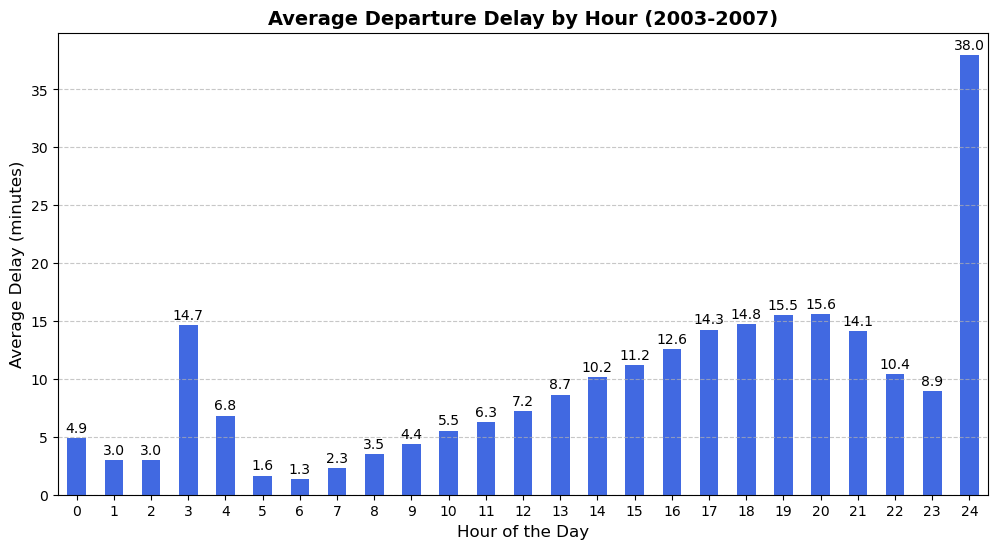

In [8]:
# Group by hour and calculate mean delay
hourly_delays = df.groupby('Hour')['DepDelay'].mean()

# Plot average departure delay by hour
plt.figure(figsize=(12,6))
hourly_delays.plot(kind='bar', color='royalblue')
plt.title("Average Departure Delay by Hour (2003-2007)", fontsize=14, fontweight='bold')
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Average Delay (minutes)", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars
for i, v in enumerate(hourly_delays):
    plt.text(i, v + 0.5, f"{v:.1f}", ha='center', fontsize=10)

plt.show()

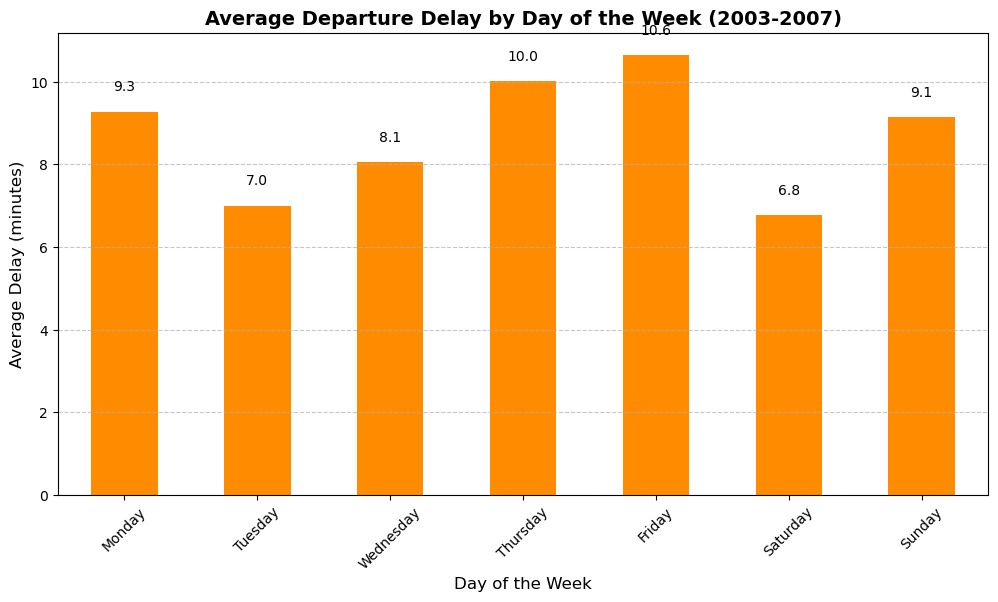


Average Delay by Day of the Week:
DayOfWeek
Monday        9.279488
Tuesday       7.002430
Wednesday     8.059205
Thursday     10.019216
Friday       10.647416
Saturday      6.771588
Sunday        9.146686
Name: DepDelay, dtype: float64


In [9]:
# Group by day of the week and calculate mean delay
daily_delays = df.groupby('DayOfWeek')['DepDelay'].mean()

# Day mapping
day_labels = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
daily_delays.index = daily_delays.index.map(day_labels)

# Plot average departure delay by day of the week
plt.figure(figsize=(12,6))
daily_delays.plot(kind='bar', color='darkorange')
plt.title("Average Departure Delay by Day of the Week (2003-2007)", fontsize=14, fontweight='bold')
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Average Delay (minutes)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars
for i, v in enumerate(daily_delays):
    plt.text(i, v + 0.5, f"{v:.1f}", ha='center', fontsize=10)

plt.show()

# Display summary statistics
print("\nAverage Delay by Day of the Week:")
print(daily_delays)

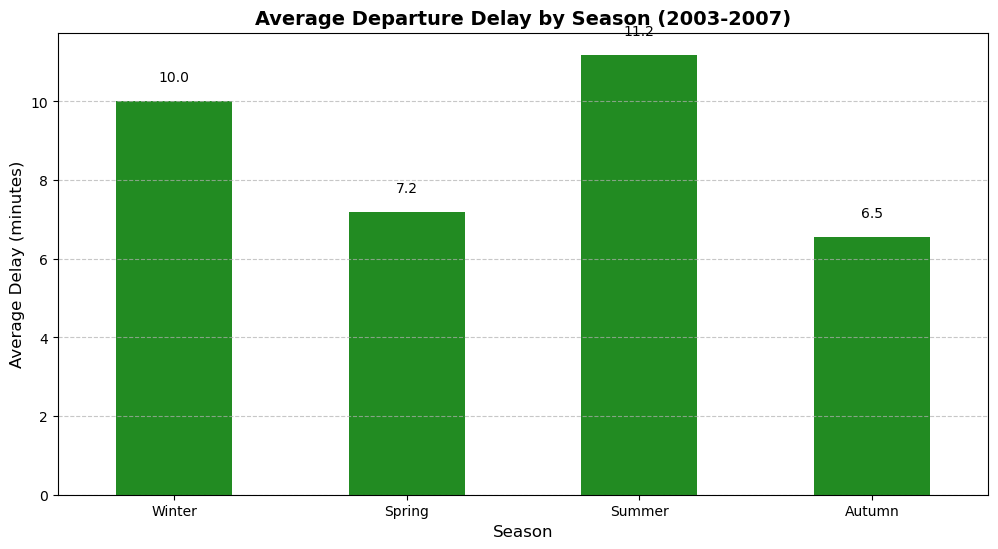

Average Delay by Season:
Season
Winter    10.012605
Spring     7.200785
Summer    11.189029
Autumn     6.548193
Name: DepDelay, dtype: float64


In [10]:
# Define seasons based on months
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(get_season)

# Group by season and calculate mean delay
seasonal_delays = df.groupby('Season')['DepDelay'].mean().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])

# Plot average departure delay by season
plt.figure(figsize=(12,6))
seasonal_delays.plot(kind='bar', color='forestgreen')
plt.title("Average Departure Delay by Season (2003-2007)", fontsize=14, fontweight='bold')
plt.xlabel("Season", fontsize=12)
plt.ylabel("Average Delay (minutes)", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars
for i, v in enumerate(seasonal_delays):
    plt.text(i, v + 0.5, f"{v:.1f}", ha='center', fontsize=10)

plt.show()

# Display summary statistics
print("Average Delay by Season:")
print(seasonal_delays)


### Q2: Do older Planes Suffer More Delays on a year to year basis

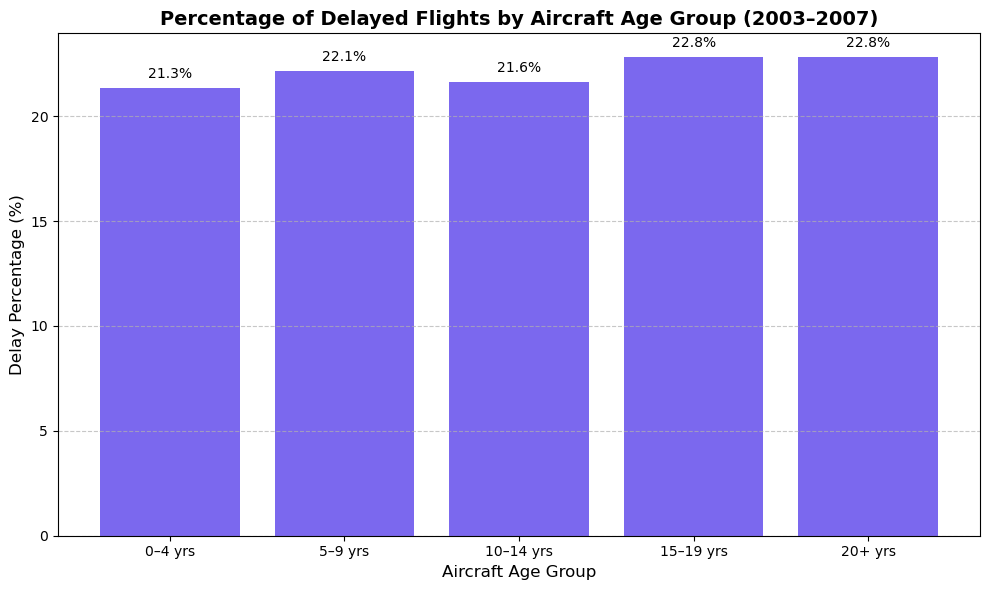

In [12]:
# Filter the required columns
flights_age = df[['Year', 'TailNum', 'ArrDelay']].copy()

# Load aircraft info
aircraft_info = pd.read_csv("aircraft_info.csv", usecols=["tailnum", "year"])

# Merge with aircraft info to get manufacture year
flights_age = flights_age.merge(aircraft_info, left_on="TailNum", right_on="tailnum", how="left")

# Drop rows with missing manufacture year or arrival delay
flights_age = flights_age.dropna(subset=["year", "ArrDelay"])

# Calculate aircraft age
flights_age["AircraftAge"] = flights_age["Year"] - flights_age["year"]
flights_age = flights_age[flights_age["AircraftAge"] >= 0]

# Define age categories
bins = [0, 4, 9, 14, 19, 100]
labels = ["0–4 yrs", "5–9 yrs", "10–14 yrs", "15–19 yrs", "20+ yrs"]
flights_age["AgeGroup"] = pd.cut(flights_age["AircraftAge"], bins=bins, labels=labels)

# Flag flights with arrival delay >= 15 mins
flights_age["IsDelayed"] = flights_age["ArrDelay"] >= 15

# Group and calculate delay percentage
grouped = flights_age.groupby("AgeGroup", observed=False)["IsDelayed"].agg(["sum", "count"])
grouped["DelayPercentage"] = (grouped["sum"] / grouped["count"]) * 100
grouped = grouped.rename(columns={"sum": "DelayedFlights", "count": "TotalFlights"})

# ------------------ Plotting ------------------
plt.figure(figsize=(10, 6))
age_groups = grouped.index.astype(str)
delay_percentages = grouped["DelayPercentage"]

bars = plt.bar(age_groups, delay_percentages, color='mediumslateblue')

plt.title("Percentage of Delayed Flights by Aircraft Age Group (2003–2007)", fontsize=14, fontweight='bold')
plt.xlabel("Aircraft Age Group", fontsize=12)
plt.ylabel("Delay Percentage (%)", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f"{yval:.1f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

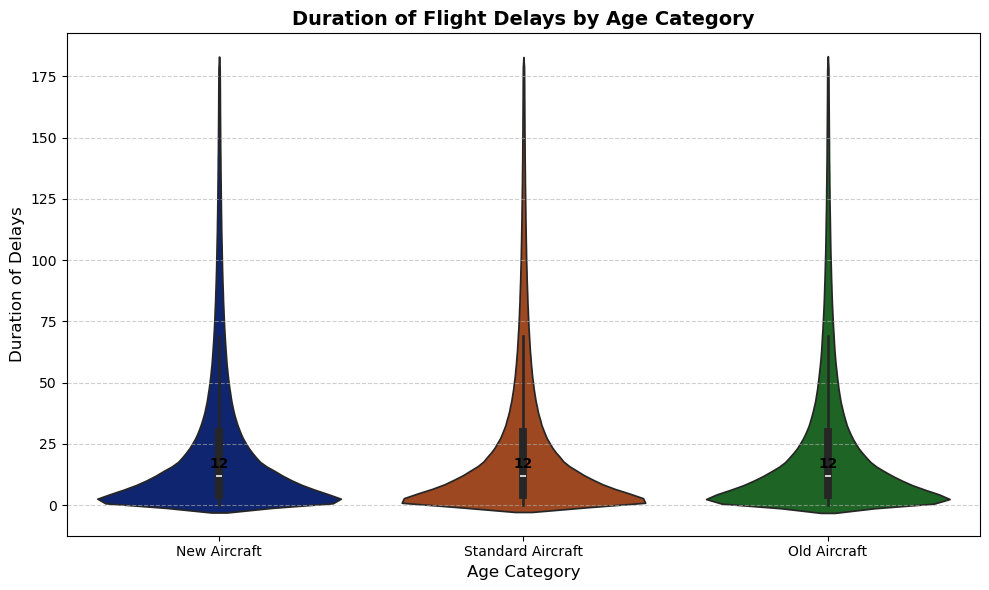

In [13]:
# Prepare data
flights_violin = df[['Year', 'TailNum', 'ArrDelay']].copy()
aircraft_info = pd.read_csv("aircraft_info.csv", usecols=["tailnum", "year"])
flights_violin = flights_violin.merge(aircraft_info, left_on="TailNum", right_on="tailnum", how="left")
flights_violin = flights_violin.dropna(subset=["year", "ArrDelay"])
flights_violin["AircraftAge"] = flights_violin["Year"] - flights_violin["year"]
flights_violin = flights_violin[flights_violin["AircraftAge"] >= 0]

# Define AgeCategory column
def age_category(age):
    if age <= 4:
        return "New Aircraft"
    elif 5 <= age <= 14:
        return "Standard Aircraft"
    else:
        return "Old Aircraft"

flights_violin["AgeCategory"] = flights_violin["AircraftAge"].apply(age_category)

# Filter for visualization clarity (optional)
flights_violin = flights_violin[(flights_violin["ArrDelay"] >= 0) & (flights_violin["ArrDelay"] <= 180)]

# Compute medians
medians = flights_violin.groupby("AgeCategory")["ArrDelay"].median()

# Reorder categories for consistent plotting
ordered_categories = ["New Aircraft", "Standard Aircraft", "Old Aircraft"]
flights_violin["AgeCategory"] = pd.Categorical(flights_violin["AgeCategory"], categories=ordered_categories, ordered=True)

# Plot violin
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=flights_violin,
    x="AgeCategory",
    y="ArrDelay",
    hue="AgeCategory",
    inner="box",
    palette="dark",
    legend=False
)

# Annotate median values
for i, cat in enumerate(ordered_categories):
    median_val = medians[cat]
    plt.text(i, median_val + 2, f"{int(median_val)}", ha='center', va='bottom', fontsize=10, fontweight='bold')

# Formatting
plt.title("Duration of Flight Delays by Age Category", fontsize=14, fontweight='bold')
plt.xlabel("Age Category", fontsize=12)
plt.ylabel("Duration of Delays", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Qn 3: Logistic Regression model

Processing year: 2003
Processing year: 2004
Processing year: 2005
Processing year: 2006
Processing year: 2007


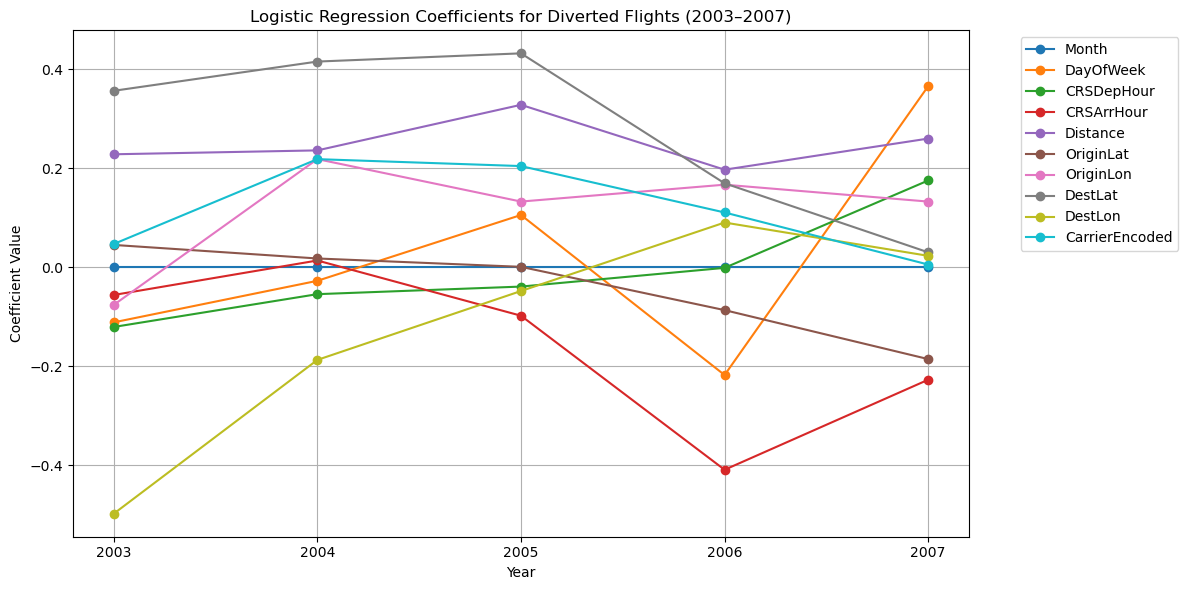

In [15]:
# Load airport coordinates
airports = pd.read_csv("airports.csv")
airport_coords = airports[["iata", "lat", "long"]].rename(columns={"iata": "Airport"})

# Columns to use
columns = ["Month", "DayOfWeek", "CRSDepTime", "CRSArrTime",
           "UniqueCarrier", "Origin", "Dest", "Distance", "Diverted"]

# Prepare to store coefficients
coef_list = []
years = range(2003, 2008)

# Label encoders
le_carrier = LabelEncoder()
le_origin = LabelEncoder()
le_dest = LabelEncoder()

for year in years:
    print(f"Processing year: {year}")
    df = pd.read_csv(f"{year}.csv.bz2", usecols=columns, low_memory=False, nrows=200000)
    df = df.dropna()

    # Convert times to hours
    df["CRSDepHour"] = df["CRSDepTime"] // 100
    df["CRSArrHour"] = df["CRSArrTime"] // 100

    # Merge origin airport coordinates
    df = df.merge(airport_coords, left_on="Origin", right_on="Airport", how="left")
    df = df.rename(columns={"lat": "OriginLat", "long": "OriginLon"})
    df = df.drop(columns=["Airport"])

    # Merge destination airport coordinates
    df = df.merge(airport_coords, left_on="Dest", right_on="Airport", how="left")
    df = df.rename(columns={"lat": "DestLat", "long": "DestLon"})
    df = df.drop(columns=["Airport"])

    # Encode categorical variables
    df["CarrierEncoded"] = le_carrier.fit_transform(df["UniqueCarrier"])
    df["OriginEncoded"] = le_origin.fit_transform(df["Origin"])
    df["DestEncoded"] = le_dest.fit_transform(df["Dest"])

    # Fill any missing coordinates with 0s
    df = df.fillna(0)

    # Select features and target
    features = ["Month", "DayOfWeek", "CRSDepHour", "CRSArrHour", "Distance",
                "OriginLat", "OriginLon", "DestLat", "DestLon", "CarrierEncoded"]
    X = df[features]
    y = df["Diverted"]

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit logistic regression model
    model = LogisticRegression(class_weight="balanced", max_iter=1000)
    model.fit(X_scaled, y)

    # Store coefficients
    coef_list.append(pd.Series(model.coef_[0], index=features, name=str(year)))

# Combine coefficients across years
coef_df = pd.concat(coef_list, axis=1)

# Plotting coefficients across years
plt.figure(figsize=(12, 6))
for feature in coef_df.index:
    plt.plot(coef_df.columns, coef_df.loc[feature], marker='o', label=feature)

plt.title("Logistic Regression Coefficients for Diverted Flights (2003–2007)")
plt.xlabel("Year")
plt.ylabel("Coefficient Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
